In [1]:
import numpy as np 
import pandas as pd

from data import RandomData, AmazonBooks, ToyData, MovieLensData
from model import RandomModel, CombinedMeanModel, ItemItemCollaborationModel

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

### Load Data

In [3]:
ds = MovieLensData(min_user_ratings=5).get_dataset(verbose=True)
train = ds['train']
val = ds['val']

loading preprocessed dataset from disk


In [4]:
(len(ds['test']['user_product_ratings']),
 len(ds['val']['user_product_ratings']),
 len(ds['train']['user_product_ratings']))

(2702933, 2754434, 5097362)

In [5]:
train['user_product_ratings'].rating.value_counts()

4.0    1435242
3.0    1043209
5.0    1021570
3.5     435754
4.5     427696
2.0     297769
1.0     162929
2.5     150745
0.5      67362
1.5      55086
Name: rating, dtype: int64

In [6]:
len(set(ds['train']['user_product_ratings'].user_id))

179307

In [7]:
len(set(ds['val']['user_product_ratings'].user_id))

214990

In [8]:
(len(ds['test']['product_descriptions']),
 len(ds['val']['product_descriptions']),
 len(ds['train']['product_descriptions']))

(11046, 11120, 10640)

In [9]:
(len(ds['test']['product_reviews']),
 len(ds['val']['product_reviews']),
 len(ds['train']['product_reviews']))

(73038, 72454, 88503)

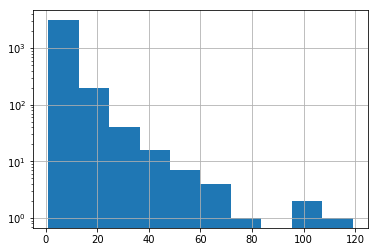

In [10]:
ds['train']['user_product_ratings'].groupby('user_id')['rating'].count().hist(log=True)

### Accuracy Metrics

In [11]:
def mean_squared_error(pred, ground_truth):
    return np.mean((pred - ground_truth) ** 2.)

In [12]:
def accuracy(pred, ground_truth):
    return (np.round(pred) == ground_truth).sum() / float(len(pred))

In [13]:
def evaluate_model(model, train, val, loss_fn):
    model.fit(train)
    train_up_rat = train['user_product_ratings']
    val_up_rat = val['user_product_ratings'].copy()
    val_up_rat['pred'] = model.predict(val_up_rat[['user_id', 'product_id']])
    
    train_users = set(train['user_product_ratings'].user_id)
    train_products = set(train['user_product_ratings'].product_id)
    
    train_loss = loss_fn(model.predict(train_up_rat[['user_id', 'product_id']]),
                         train_up_rat.rating)
    
    val_loss = loss_fn(model.predict(val_up_rat[['user_id', 'product_id']]),
                       val_up_rat.rating)
    
    A_data = val_up_rat[val_up_rat.user_id.isin(train_users) & 
                        val_up_rat.product_id.isin(train_products)]
    A_loss = loss_fn(A_data.pred, A_data.rating)
    
    B_data = val_up_rat[~val_up_rat.user_id.isin(train_users) &
                        val_up_rat.product_id.isin(train_products)]
    B_loss = loss_fn(B_data.pred, B_data.rating)
    
    C_data = val_up_rat[val_up_rat.user_id.isin(train_users) &
                        ~val_up_rat.product_id.isin(train_products)]
    C_loss = loss_fn(C_data.pred, C_data.rating)
    
    D_data = val_up_rat[~val_up_rat.user_id.isin(train_users) &
                        ~val_up_rat.product_id.isin(train_products)]
    D_loss = loss_fn(D_data.pred, D_data.rating)
    
    print('\n'.join(
        ['     Products',
         '    -----------',
         '   |       |   |  (A.x) TRAIN SET',
         ' U | (A.x) |   |  (A.o) VAL CELL HOLDOUT',
         ' s | (A.o) |(C)|    (B) VAL USER HOLDOUT',
         ' e |       |   |    (C) VAL PRODUCT HOLDOUT',
         ' r |       |   |    (D) VAL PRODUCT & USER HOLDOUT',
         ' s |-------|---|    (V) VAL SET',
         '   |  (B)  |(D)|',
         '    -----------',
         '================================',
         '']))
    
    def stats(data, loss, lbl):
        print(lbl)
        print(f'      Number of users: {len(set(data.user_id))}')
        print(f'      Number of proucts: {len(set(data.product_id))}')
        print(f'      Number of ratings: {len(data)}')
        print(f'      loss: {loss}\n')
    stats(train_up_rat, train_loss, '(A.x) TRAIN SET')
    stats(val_up_rat, val_loss, '  (V) VAL SET')
    stats(A_data, A_loss, '(A.o) VAL CELL HOLDOUT')
    stats(B_data, B_loss, '  (B) VAL USER HOLDOUT')
    stats(C_data, C_loss, '  (C) VAL PRODUCT HOLDOUT')
    stats(D_data, D_loss, '  (D) VAL PRODUCT & USER HOLDOUT')
    return val_loss, A_loss, B_loss, C_loss, D_loss

In [14]:
model = ItemItemCollaborationModel()
_ = evaluate_model(model, train, val, mean_squared_error)

NameError: name 'users' is not defined

In [ ]:
model = SimpleMeanModel()
_ = evaluate_model(model, train, val, mean_squared_error)

In [15]:
model = UserMeanModel()
_ = evaluate_model(model, train, val, mean_squared_error)

NameError: name 'UserMeanModel' is not defined

In [16]:
model = ProductMeanModel()
_ = evaluate_model(model, train, val, mean_squared_error)

NameError: name 'ProductMeanModel' is not defined

In [17]:
model = CombinedMeanModel()
_ = evaluate_model(model, train, val, mean_squared_error)

     Products
    -----------
   |       |   |  (A.x) TRAIN SET
 U | (A.x) |   |  (A.o) VAL CELL HOLDOUT
 s | (A.o) |(C)|    (B) VAL USER HOLDOUT
 e |       |   |    (C) VAL PRODUCT HOLDOUT
 r |       |   |    (D) VAL PRODUCT & USER HOLDOUT
 s |-------|---|    (V) VAL SET
   |  (B)  |(D)|
    -----------

(A.x) TRAIN SET
      Number of users: 3381
      Number of proucts: 9088
      Number of ratings: 21175
      loss: 0.30779498747098

  (V) VAL SET
      Number of users: 3404
      Number of proucts: 6431
      Number of ratings: 11588
      loss: 1.0806971070500666

(A.o) VAL CELL HOLDOUT
      Number of users: 1491
      Number of proucts: 1827
      Number of ratings: 2195
      loss: 1.2075150970715742

  (B) VAL USER HOLDOUT
      Number of users: 619
      Number of proucts: 2424
      Number of ratings: 3175
      loss: 1.1184449993859649

  (C) VAL PRODUCT HOLDOUT
      Number of users: 2117
      Number of proucts: 1912
      Number of ratings: 4131
      loss: 0.9888275083

In [11]:
import model
import imp
imp.reload(model)

<module 'model' from '/Users/gili/Documents/stanford/junior/cs224u/cs224u/cs224u_project/model.py'>

In [126]:
import csv
def load_glove(glove_data_file):
        words = pd.read_table(glove_data_file, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)
        return words

def convert_word_to_vec(model, w, embed_size, verbose=True):
    if w in model.index:
        if verbose: 
            print("found")
        return model.loc[w].as_matrix()
    else:
        if verbose: 
            print("not found")
        return np.random.normal(0, 0.7, embed_size)


import matplotlib.pyplot as plt
def randomly_sample(model):
    all_words = []
    count = 0
    for w in model.index:
        all_words.append(model.loc[w].as_matrix())
        if count > 1000:
            plt.hist(np.array(all_words).flatten())
            return
        count += 1
    
import os
def create_vsm(corpus, embed_size=50, glove_file_path='glove.6B'):
    vsm_list = []
    vocab = set(corpus)
    assert(embed_size == 50 or embed_size==100)
    glove_file = os.path.join(glove_file_path, 'glove.6B.%dd.txt' % embed_size)
    model = None
    model = load_glove(glove_file)
    if model is not None:
        for word in vocab:
            word_as_vec = convert_word_to_vec(model, word, embed_size)
            vsm_list.append(word_as_vec)
    return np.array(vsm_list)


In [130]:
# Testing vsms
test_1 = create_vsm(['hi', 'bye', 'can', 'not', 'more', 'words', 'next', 'other', 'work', 'bye', 'can', 'not', 'more', 'words', 'next', 'other', 'work'], embed_size=100)
test_2 = create_vsm(['hi', 'bye', 'askfdklsd'], embed_size=100)
test_3 = create_vsm(['lkadsfj', 'hello', 'be'], embed_size=50)
test_4 = create_vsm(['hi', 'askfdklsd', 'bye'], embed_size=100)
#test_5 = create_vsm(['hi'], embed_size = 60)
print(test_1)
print(test_2)

found
found
found
found
found
found
found
found
found
found
found
not found
not found
found
found
found
found
not found
[[ 7.2607e-02  7.0889e-01  4.2583e-01 -5.6344e-02 -2.7468e-01  1.0245e+00
  -3.4179e-01 -8.0244e-01 -1.7076e-01 -3.4955e-01 -3.3893e-02  1.5975e-01
   1.1722e-01  4.6308e-01 -2.1898e-01 -1.1145e-01 -2.5906e-01 -1.6977e-01
  -6.1767e-01 -2.5274e-01  6.7205e-01 -2.2908e-01 -1.5565e-01  8.5560e-03
   2.2689e-01 -1.3908e-01 -5.4157e-02  1.0742e-01  2.3514e-01 -8.9140e-02
   1.4436e-01  7.9394e-01 -5.7136e-01 -2.5193e-01 -3.9158e-01 -1.3934e-01
  -3.8139e-01 -9.4135e-02  2.6057e-01  7.7475e-02 -1.4822e-01 -4.1464e-01
   2.5563e-03  4.4005e-02 -7.7818e-01 -1.5953e-01 -6.1808e-02 -3.9439e-01
  -5.2755e-01 -6.2012e-01  7.1911e-01 -1.0982e-02  1.1115e+00  8.0687e-01
  -3.1538e-01 -1.6293e+00  3.3266e-02 -6.3853e-02  6.1646e-01 -1.0547e-01
   3.5890e-01  1.4457e+00 -4.6421e-01 -7.5587e-01  6.4232e-01 -1.6544e-01
   9.0204e-01  1.5494e-01 -2.8529e-02 -7.4347e-01 -5.7556e-01  4.2

In [ ]:
model = load_glove('glove.6B/glove.6B.100d.txt')
randomly_sample(model)

In [108]:
ls = []
ls.append(np.array([4,5,6]))
ls.append([1,2,3])


In [109]:
np.array(ls)

array([[4, 5, 6],
       [1, 2, 3]])

In [129]:
import codecs
from collections import defaultdict
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
import scipy.spatial.distance
import sys
def lsa(df, k=100):
    """Latent Semantic Analysis using pure scipy.
    Parameters
    ----------
    df : pd.DataFrame
       The matrix to operate on.
    k : int (default: 100)
        Number of dimensions to truncate to.
    Returns
    -------
    pd.DataFrame
        The SVD-reduced version of `df` with dimension (m x k), where
        m is the rowcount of mat and `k` is either the user-supplied
        k or the column count of `mat`, whichever is smaller.
    """
    rowmat, singvals, colmat = np.linalg.svd(df, full_matrices=False)
    singvals = np.diag(singvals)
    trunc = np.dot(rowmat[:, 0:k], singvals[0:k, 0:k])
    return pd.DataFrame(trunc, index=df.index)


In [ ]:
def create_vsm(corpus, embed_size=50):
    lsa()